In [2]:
from CNN_net import SimpleVGGNet
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers.legacy import SGD
from keras.preprocessing.image import ImageDataGenerator
import utils_paths
import matplotlib.pyplot as plt
import cv2
import numpy as np
import argparse
import random
import pickle
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.resnet import ResNet152
import os
from keras.layers import Dense
from keras.models import Model

2023-11-26 03:08:30.916788: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 03:08:32.886353: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
image_size = 255
base_model = ResNet101(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(image_size, image_size,3),
    pooling="max"
)

x = base_model.output
x = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)
# for layer in base_model.layers:
#     layer.trainable = False

2023-11-26 03:08:45.013357: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-26 03:08:45.415650: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-26 03:08:45.416481: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:

# 读取数据和标签
print("------开始读取数据------")
data = []
labels = []

# 拿到图像数据路径，方便后续读取
imagePaths = sorted(list(utils_paths.list_images('./dataset')))
random.seed(42)
random.shuffle(imagePaths)

image_size = 255
# 遍历读取数据
for imagePath in imagePaths:
    # 读取图像数据
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (image_size, image_size))
    data.append(image)
    # 读取标签
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# 数据集切分
(trainX, testX, trainY, testY) = train_test_split(data,labels, test_size=0.25, random_state=42)

# 转换标签为one-hot encoding格式
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
print(lb.classes_)

# 数据增强处理
aug = ImageDataGenerator(
    rotation_range=30, 
    width_shift_range=0.1,
    height_shift_range=0.1, 
    shear_range=0.2, 
    zoom_range=0.2,
    horizontal_flip=True, 
    fill_mode="nearest")

------开始读取数据------
['button' 'keyboard' 'searchbar' 'switch']


In [18]:
# 设置初始化超参数

# 学习率
INIT_LR = 0.01
# Epoch  
# 这里设置 5 是为了能尽快训练完毕，可以设置高一点，比如 30
EPOCHS = 15
# Batch Size
BS = 32

# 损失函数，编译模型
print("------开始训练网络------")

opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

# 训练网络模型
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), 
    steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS
)


# 测试
print("------测试网络------")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))



------开始训练网络------
Epoch 1/15
76/76 [==============================] - 50s 522ms/step - loss: 0.4352 - accuracy: 0.8359 - val_loss: 0.3718 - val_accuracy: 0.8913
Epoch 2/15
76/76 [==============================] - 36s 467ms/step - loss: 0.3797 - accuracy: 0.8540 - val_loss: 0.3587 - val_accuracy: 0.8828
Epoch 3/15
76/76 [==============================] - 36s 471ms/step - loss: 0.3839 - accuracy: 0.8528 - val_loss: 0.4226 - val_accuracy: 0.8523
Epoch 4/15
76/76 [==============================] - 36s 464ms/step - loss: 0.3481 - accuracy: 0.8779 - val_loss: 0.2649 - val_accuracy: 0.9084
Epoch 5/15
76/76 [==============================] - 36s 476ms/step - loss: 0.3331 - accuracy: 0.8808 - val_loss: 0.2619 - val_accuracy: 0.9158
Epoch 6/15
76/76 [==============================] - 36s 469ms/step - loss: 0.3012 - accuracy: 0.8887 - val_loss: 0.2687 - val_accuracy: 0.9109
Epoch 7/15
76/76 [==============================] - 36s 472ms/step - loss: 0.3086 - accuracy: 0.8891 - val_loss: 0.3333 - v

1/1 [==============================] - 0s 39ms/step
[[9.99907494e-01 2.99720512e-07 7.88984107e-05 1.32312107e-05]
 [4.00320828e-01 2.87881447e-03 6.36478513e-02 5.33152461e-01]
 [1.57951110e-03 9.61345673e-01 1.08015221e-02 2.62732934e-02]
 [6.77199932e-05 9.99245882e-01 3.68306239e-04 3.18114646e-04]
 [9.16527767e-07 9.99969721e-01 1.71235638e-06 2.75898165e-05]
 [1.58734678e-04 1.92281841e-05 9.99473035e-01 3.49007372e-04]
 [8.80475389e-04 5.50313371e-06 9.99010921e-01 1.03113962e-04]
 [7.76313990e-02 1.32126315e-05 9.22142029e-01 2.13322637e-04]
 [1.13544804e-04 2.58623913e-04 1.48203305e-03 9.98145819e-01]
 [7.03648780e-04 1.65182038e-03 7.26117613e-03 9.90383327e-01]
 [2.41825387e-01 1.72689336e-03 4.23529372e-02 7.14094758e-01]
 [1.13858073e-03 8.09773155e-06 1.03594188e-03 9.97817397e-01]]
[9.9990749e-01 2.9972051e-07 7.8898411e-05 1.3231211e-05]
['../predict-project/test/button.png', 'button'] 的预测结果为： button
[0.40032083 0.00287881 0.06364785 0.53315246]
['../predict-project/te

/opt/conda/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


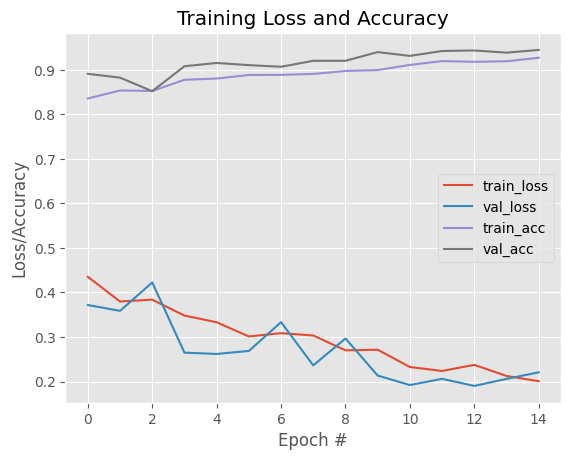

In [19]:


testPaths = [
    ["../predict-project/test/button.png","button"],
    ["../predict-project/test/button2.jpg","button"],
    ["../predict-project/test/keybord.jpg","keybord"],
    ["../predict-project/test/keybord2.jpeg","keybord"],
    ["../predict-project/test/keybord3.jpg","keybord"],
    ["../predict-project/test/searchbar.png","searchbar"],
    ["../predict-project/test/searchbar2.jpg","searchbar"],
    ["../predict-project/test/searchbar3.jpg","searchbar"],
    ["../predict-project/test/switch.jpg","switch"],
    ["../predict-project/test/switch2.jpg","switch"],
    ["../predict-project/test/switch3.jpg","switch"],
    ["../predict-project/test/switch4.jpg","switch"],
    ]

images = []
for testPath in testPaths:
    image = cv2.imread(testPath[0])
    # image = cv2.cvtColor(image,cv2.CLOLR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(255,255))
    images.append(image)

images = np.asarray(images)
images = np.array(images, dtype="float") / 255.0
pred = model.predict(images)

print(pred)
for i in range(len(testPaths)):
    print(pred[i])
    max_ = np.argmax(pred[i])
    print(testPaths[i],'的预测结果为：',lb.classes_[max_])


# 绘制结果曲线
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('./cnn_plot.png')

# 保存模型
print("------保存模型------")
model.save('./cnn.model.resnet101.h5')
f = open('./cnn_lb.pickle', "wb")
f.write(pickle.dumps(lb))
f.close()